In [49]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
#performs the forward operator (radon transform with a collection of line integrals)    
from skimage.transform import radon, iradon, resize
from skimage.data import shepp_logan_phantom
#Setting up the problem
from sklearn.datasets import fetch_openml
from skimage.restoration import denoise_tv_chambolle
from bm3d import bm3d

#MNIST data
X, y = fetch_openml("mnist_784", version=1, return_X_y=True,
as_frame=False, parser="pandas")
x_3 = X[111].astype('double')
x_8 = X[333].astype('double')
imsize = (28, 28)

#plotting for the sinogram
def show_image(x, title):
    plt.title(title)
    plt.imshow(np.reshape(x, imsize))
    c = plt.colorbar()
    c.remove()


    

theta = range(0,359, 13)


def trans(x):
    return radon(np.reshape(x, imsize), theta).ravel()

n = np.prod(imsize)
e = np.zeros(n)
A = np.zeros((n,n))
for i in range(len(e)):
    e[i] = 1
    Ae = trans(e)
    e[i] = 0
    A[:,i] = Ae







c:\Users\as5057\python-test\venv\Lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


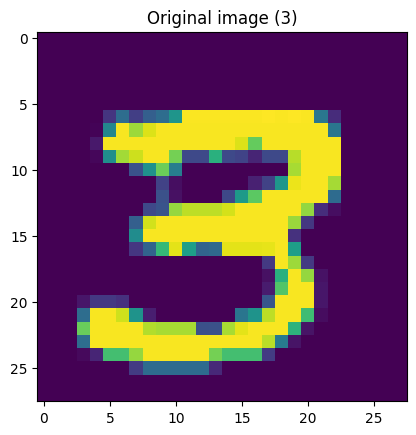

In [53]:
show_image(x_3, title = "Original image (3)")

c:\Users\as5057\python-test\venv\Lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


Text(0.5, 1.0, 'Sinogram')

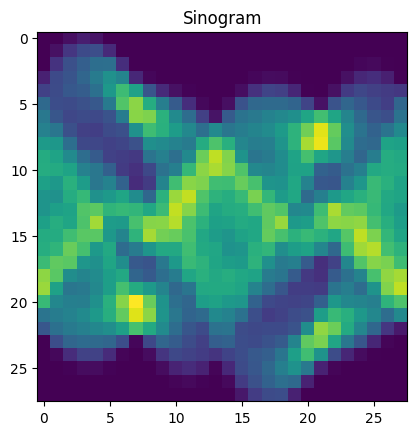

In [56]:
digit_sinogram =trans(x_3)
plt.imshow(np.reshape(digit_sinogram, imsize))
plt.title('Sinogram')

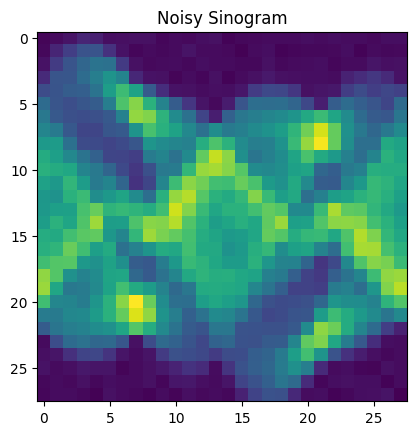

In [57]:
digit_sinogram =trans(x_3)
noisy_digit = digit_sinogram + 50*np.random.standard_normal(digit_sinogram.shape) #Noise added to the system
plt.title("Noisy Sinogram")
plt.imshow(np.reshape(noisy_digit, imsize))

(28, 28)

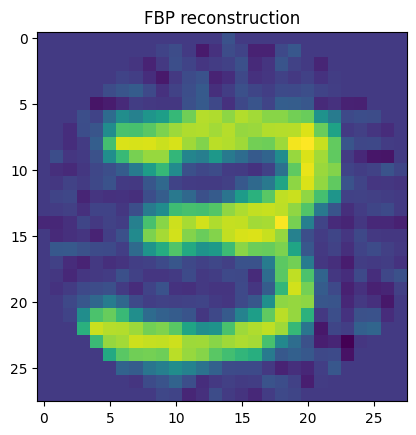

In [71]:
angles = range(0,359, 13)
fbp_noisy = iradon(np.reshape(noisy_digit, imsize), theta=theta, circle=True)
plt.imshow(fbp_noisy)
plt.title("FBP reconstruction")


In [117]:
import pnp_mace as pnpm

# plotting, NRMSE, denoiser functions
def display_images(image_list, image_titles, ground_truth):
    titles = []
    for img, title in zip(image_list, image_titles):
        
        #cur_min = np.round(np.amin(img), 1)
        #cur_max = np.round(np.amax(img), 1)
        #bounds = '{} to {}'.format(str(cur_min), str(cur_max))
        #psnr = PSNR(ground_truth, img)
        #titles.append(title + ' [PSNR: ' + str(psnr) + ']')

        nrmse = pnpm.nrmse(img, ground_truth)
        titles.append(title + ' [NRMSE: ' + str(nrmse) + ']')

    for img, title in zip(image_list, titles):
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4.5, 5))
        

        ax.imshow(img)
        #pnpm.display_image(img, fig=fig, ax=ax, cmap='gray')

        plt.suptitle(title)
        plt.tight_layout()
        fig.show()



def nrmse(x, x_ground_truth):
        """
        Normalised root mean square error between final prediction and ground truth image
        """
        return np.linalg.norm(x - x_ground_truth)/np.linalg.norm(x_ground_truth)


def apply_denoiser(x, method):
        """
        Denoiser options for the u step (replacing the proximal operator)
        """
        if method == 'tv':
            return denoise_tv_chambolle(x, weight = 0.3)
        elif method == 'bm3d':
            return bm3d(x, sigma_psd = 0.9)
        elif method == 'proximal':
            return np.sign(x)*np.maximum(0, x)

In [102]:
#Noisy measurement sinogram 
b = noisy_digit 
#result_tv, metrics_tv = pnp_admm_mnist(A, b, x_3, 'tv', niter = 40)
#result_bm3d, metrics_bm3d = pnp_admm_mnist(A, b, x_3, 'bm3d', niter = 40)

In [120]:
x_ground_truth = x_3
niter = 400
rho = 0.2

#defining the 3 variables for use
x = np.zeros_like(x_ground_truth)
u = np.zeros_like(x_ground_truth)
v = np.zeros_like(x_ground_truth)
metric_list = []

#PnP ADMM iteration performed on the 3 variables
for i in tqdm(range(niter), desc = 'PnP ADMM iterations'):

    #FBP inversion
    measurement = np.reshape(b, imsize)
    #print("measurement", measurement.shape)
    correction = np.reshape(A@(rho*(u - v)), imsize)
    #print("correction:", correction.shape)
    fbp = measurement + correction
    #print("fbp:", fbp.shape)
    x = iradon(np.reshape(fbp, imsize), theta= theta, filter_name='ramp', circle=True)
    #print("x fbp:", x.shape)

    # reshaping u and v for the denoiser (1D to 2D)
    u = u.reshape(imsize)
    v = v.reshape(imsize)
    #print("v:", v.shape)
    u = apply_denoiser(x + v, 'tv')
    v += x - u

    #flattening u and v for the next iteration when applying FBP (2D to 1D)
    u = u.flatten()
    v = v.flatten()

    current_nrmse = nrmse(x.flatten(), x_ground_truth.flatten())
    metric_list.append(current_nrmse)


PnP ADMM iterations: 100%|██████████| 400/400 [00:01<00:00, 279.38it/s]


In [119]:
def pnp_admm_mnist(b, x_ground_truth, denoiser, rho = 0.1, niter = 20, n_angles = 13):
    """
    MNIST digit version using the radon built in function
    Alternating directions method of multiplers with different denoisers to use  
    """     
        
    #defining the 3 variables for use
    x = np.zeros_like(x_ground_truth)
    u = np.zeros_like(x_ground_truth)
    v = np.zeros_like(x_ground_truth)
    metric_list = []

    #PnP ADMM iteration performed on the 3 variables
    for i in tqdm(range(niter), desc = 'PnP ADMM iterations'):

        #FBP inversion
        measurement = np.reshape(b, imsize)
        #print("measurement", measurement.shape)
        correction = np.reshape(A@(rho*(u - v)), imsize)
        #print("correction:", correction.shape)
        fbp = measurement + correction
        #print("fbp:", fbp.shape)
        x = iradon(np.reshape(fbp, imsize), theta= theta, filter_name='ramp', circle=True)
        #print("x fbp:", x.shape)

        # reshaping u and v for the denoiser (1D to 2D)
        u = u.reshape(imsize)
        v = v.reshape(imsize)
        #print("v:", v.shape)
        u = apply_denoiser(x + v, 'proximal')
        v += x - u

        #flattening u and v for the next iteration when applying FBP (2D to 1D)
        u = u.flatten()
        v = v.flatten()

        current_nrmse = nrmse(x.flatten(), x_ground_truth.flatten())
        metric_list.append(current_nrmse)



    return x, metric_list

result_tv, metrics_tv = pnp_admm_mnist(A, b, x, 'proximal', niter = 40)

PnP ADMM iterations:   0%|          | 0/40 [00:00<?, ?it/s]


ValueError: cannot reshape array of size 614656 into shape (28,28)

C:\Users\as5057\AppData\Local\Temp\ipykernel_1664\3980918012.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


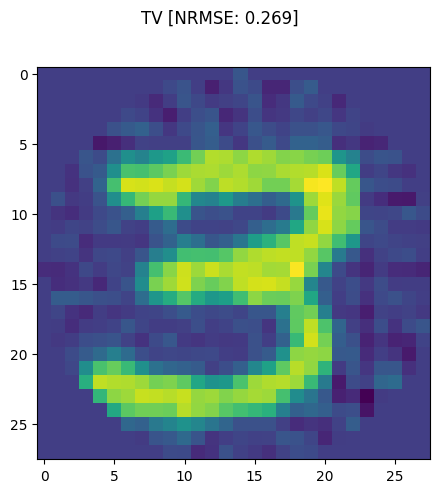

In [121]:
display_images([x], ['TV'], np.reshape(x_3, imsize))